In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import sys
from pathlib import Path
import numpy as np

In [117]:
sns.set_style("darkgrid", 
      {'axes.facecolor': '#eeeeee',
     'axes.labelcolor': '0',
     'text.color': '0',
     'xtick.color': '0',
     'ytick.color': '0',
     'xtick.bottom': True,
      })
sns.set_context("notebook")

# SI 5: Reanalysis of sediment samples from Denisova Cave, Main Chamber
## 2. Human Capture Data

We now only analyze the libraries captured with the AA163 probeset (human mt DNA), followed by a human lineage assignment test. 

Zavala et al., 2021 wrote: 
 
>  - Libraries that were identified as containing **ancient hominin DNA** were then evaluated for support of known hominin mitochondrial groups 
>  - The presence of ancient modern human mtDNA was evaluated by restricting the analysis to **deaminated fragments** to mitigate the effect of present-day human DNA contamination


So we also skipped the false-positive removal filters in the analysis of the human DNA

### Get the correct coordinates within the Main chamber profile

In [118]:
#The sheet is a table representing the coordinates in x and y **cells**
# like this:
#    x1  x2  x3  x4
# Y1 NA  NA  NA M2
# Y2 NA  M24 NA M3
# Y3 NA  M23 NA M4
# Y4 NA  M22 M1 M5

coord = pd.read_csv("assets/SI5/zavala2021_samples_coordinates.csv", sep=";")
coord['y']=coord.index
coord.columns = [x.replace('0.','') for x in coord.columns]

In [119]:
# What I want is simpy
# Marker -> X -> Y
# So I need to melt/depivot the dataframe

coord = coord.melt(id_vars=['y'], value_vars=coord.columns)
coord = coord[(coord.value != None)&(coord.value != 0)]
coord = coord[coord.value.str.startswith("M")]
coord.columns = ['y','x','marker']

In [120]:
#convert dtypes
coord['x'] = coord.x.astype(int)
coord['y'] = coord.y.astype(int)

In [121]:
#find the relative points of coordx and coordy
#this is required to plot them later on top of the image
coord['relx'] = coord.x.apply(lambda x: x/max(coord['x']))
coord['rely'] = coord.y.apply(lambda x: x/max(coord['y']))

In [122]:
#now I need to add the our sample IDs to the dataframe
samples = pd.read_csv('assets/SI5/zavala2021_rinput_humanMT.txt', sep='\t')
samples = samples[samples.marker == samples.marker] #remove NaN
samples = samples[['SampleID','marker']].drop_duplicates(subset=['SampleID','marker'])
samples = {k.strip():v.strip() for k,v in zip(samples['marker'], samples['SampleID'])}
coord['SampleID'] = coord['marker'].map(samples)

### Prepare the quicksand results

We want to see how the quicksand filters affect the results. So filter the results based on breadth and percentage

In [123]:
qs = pd.read_csv("assets/SI5/quicksand_Denisova_merged_reports.tsv", sep='\t')

In [124]:
qs = qs[
    #(qs.expected_breadth_prop >= 0.5) &
    #(qs.FamPercentage >= 0.5) &
    (qs.Family=='Hominidae')&
    (qs.Ancientness=='++')
]

## AA163
### AA163: Human lineage support

This is the analysis of the human capture data from the sample samples. First we need to define the parameters

The file for the human lineage support was created using Matthias `sediment_summary_quicksand.pl` script:

```
/home/mmeyer/perlscripts/solexa/analysis/sediment_summary_quicksand.pl -db ../sediment_database.xlsx -human -query "Denisova" -coverage 0 -deam 3 > /mnt/scratch/merlin/projects/2023_quicksand_paper/04_work/20240215_rerun_Denisova/assets/20240227_mmeyer_seddb_denisova_all_nochimp0.99_deam3.tsv
```

This created summary statistics for all entries in the database that come from Denisova Cave, the Main Chamber samples are then picked in this notebook. 

Note, that this is the command for the terminal *3* positions, for only looking at the terminal *1* position, the `-deam` flag was ommitted. Also, as in the Zavala Paper, we used the sites without Chimp and 99% support for one lineage


In [125]:
MIN_SUPPORT = 10 #minimum % support per lineage
MODE = "support" #deam if only deam, support if all sequences 
TERM = 3

In [126]:
# import the quicksand perlscript results
pl = pd.read_csv(
    f"assets/SI5/quicksand_Denisova_nochimp0.99_deam3.tsv", 
    sep='\t'
) 
pl = pl.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [127]:
# now filter to include only the assignmets that pass the quicksand filter
pl = pl[pl.CapLibIDCoreDB.isin(qs.RG)].copy()

## Filter based on the quicksand report

In [128]:
# import the zavala supplements file
zavala21 = pd.read_csv("assets/SI5/zavala2021_SD1_alllibs.csv", skiprows=3)
zavala21.columns = [
    'Marker', 'SampleID', 'LysateID', 'IndexLibID', 'RawSeqs', 'ReadsFiltered', 'ReadsMapped',
    'ReadsDeduped', '%Hominin','UniqueHominin','DuplicationRate', '5CT', '3CT', '5CTCI','3CTCI',
    'Ancient', 'Deaminated(term3)', 'H_support', 'H_support_deam', 'N-HST_support', 
    'N-HST_support_deam', 'N_support','N_support_deam', 'HST_support', 'HST_support_deam',
    'D_support', 'D_support_deam','S_support', 'S_support_deam', 'D-S_support', 'D-S_support_deam'  
]


In [129]:
zavala21 = zavala21.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# remove the negative controls...
zavala21 = zavala21[zavala21.Marker == zavala21.Marker].copy()
# only keep the main-chamber
zavala21 = zavala21[zavala21.Marker.str.startswith('M')]

In [130]:
# reduce the datasheets and de-pivot
def convert_dataframe(df, style='quicksand', ancient=True):

    cols = ['IndexLibID','SampleID','Ancient','H_support_deam',f'Deaminated(term{TERM})','Pipeline','Layer']
    #account for missing columns
    cols = [x for x in cols if x in df.columns]

    aa163 = df[[x for x in df.columns if x in cols or x.endswith(MODE) ]]
    aa163 = aa163.melt(id_vars=cols, value_vars=[x for x in aa163.columns if x.endswith(MODE)])
    
    if ancient:
        # filter for ancient and significant
        if style=='quicksand':
            aa163 = aa163[aa163.Ancient == '++'].copy()
            aa163 = aa163[aa163.value.str.startswith('^^^')].copy()
        else:
            aa163 = aa163[aa163.Ancient == 'Yes'].copy()
            aa163 = aa163[aa163.value.str.startswith('**')].copy()

    #merge with the coordinates
    aa163 = aa163.merge(coord, on=["SampleID"], validate="m:1", how='left')

    #rename the technical terms
    aa163['variable'] = aa163['variable'].map(
        {
         "S_support_deam":"Sima",
         'D-S_support_deam':'Denisova',
         'D_support_deam':'Denisova',
         'H_support_deam':'Human',
         'N-HST_support_deam':'Neanderthal',
         'N_support_deam':'Neanderthal',
         "S_support":"Sima",
         'D-S_support':'Denisova',
         'D_support':'Denisova',
         'H_support':'Human',
         'N-HST_support':'Neanderthal',
         'N_support':'Neanderthal'
        }
    )
    
    if ancient:
        # keep ancient human only if _deam is significant too
        aa163 = aa163[
        (aa163[['variable', 'H_support_deam']].apply(
            lambda x: x[0]=='Human' and (x[1].startswith("^^^") or x[1].startswith("**")),axis=1)) |
        (aa163['variable']!='Human')
        ]
    
    
    return aa163

In [131]:
def print_map(df):

    #this is for the legend
    colors_dict = {
        #"Sima":"green",
        "Denisova":"red",
        "Neanderthal":"blue",
        "Human":"yellow",
    }

    handles = []
    for label,color in colors_dict.items():
        patch = mpatches.Patch(color=color, label=label)
        handles.append(patch)

    # and now the figure
    fig = plt.figure(figsize=(9, 16))
    #main frame
    back = fig.add_axes([0,0,1,1])

    #print the background
    img = plt.imread("assets/SI5/img/MAIN_SE_without column_blue and orange background.png")
    back.imshow(img)
    plt.legend(
        handles=handles, 
        prop={'size':17}, 
        facecolor='white', 
        edgecolor='black',
        bbox_to_anchor=(0,0,0.95,0.9))

    #add the points
    for n,(i,grp) in enumerate(coord.groupby('marker')):
        x = set(grp['relx']).pop() *0.85 +0.05 #this is to fit it to the padding of the image
        y = 1-set(grp['rely']).pop() *0.88 - 0.07 #
        spid = set(grp['SampleID']).pop()

        data=df[df.marker==i].copy()

        if x==x and y==y:        
            wedgeprops = {"edgecolor":"k", "linewidth":1}

            ax = fig.add_axes([x,y,0.025,0.02])
            ax.pie([1],colors=["white"], wedgeprops=wedgeprops) #plot an empty white pie for negative

            #now check if 
            data['support'] = data['value'].apply(lambda x: int(re.search("[0-9]+",x).group()))
            data['sizes'] = data['value'].apply(lambda x: int(re.search("(?<=\()[0-9]+",x).group()))

            data=data[data.support > MIN_SUPPORT].copy()        
            data = data.groupby("variable",as_index=False).mean()

            if 'sizes' in data.columns:
                colors = [colors_dict[x] if x in colors_dict else "grey" for x in data["variable"]]
                ax.pie(data['sizes'], colors=colors, wedgeprops=wedgeprops)
                   

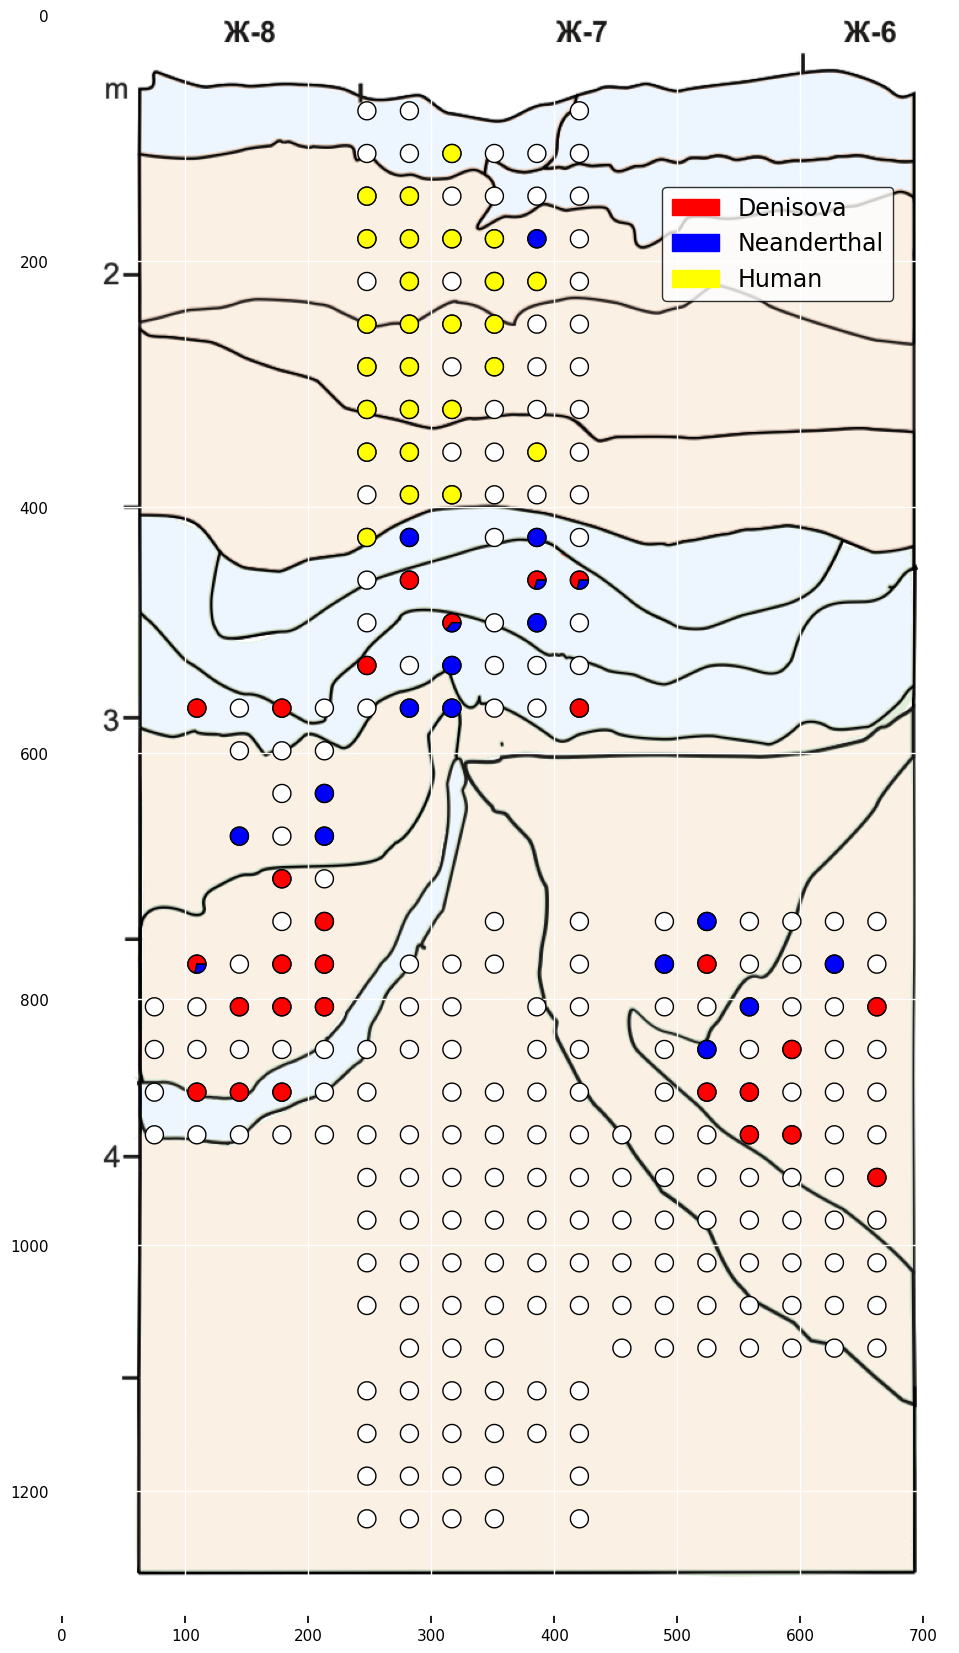

In [132]:
zav = convert_dataframe(zavala21, style='megan')
print_map(zav)

In [133]:
# get some basic stats about number of samples etc
zavala21['AncientCount'] = zavala21['Ancient'].apply(lambda x: x=='Yes')

zav_count = zavala21.groupby('SampleID', as_index=False).sum()
print('Ancient: ', len(zav_count[zav_count['AncientCount'] > 0]))
print('Negative: ', len(zav_count[zav_count['AncientCount'] == 0]))

Ancient:  78
Negative:  196


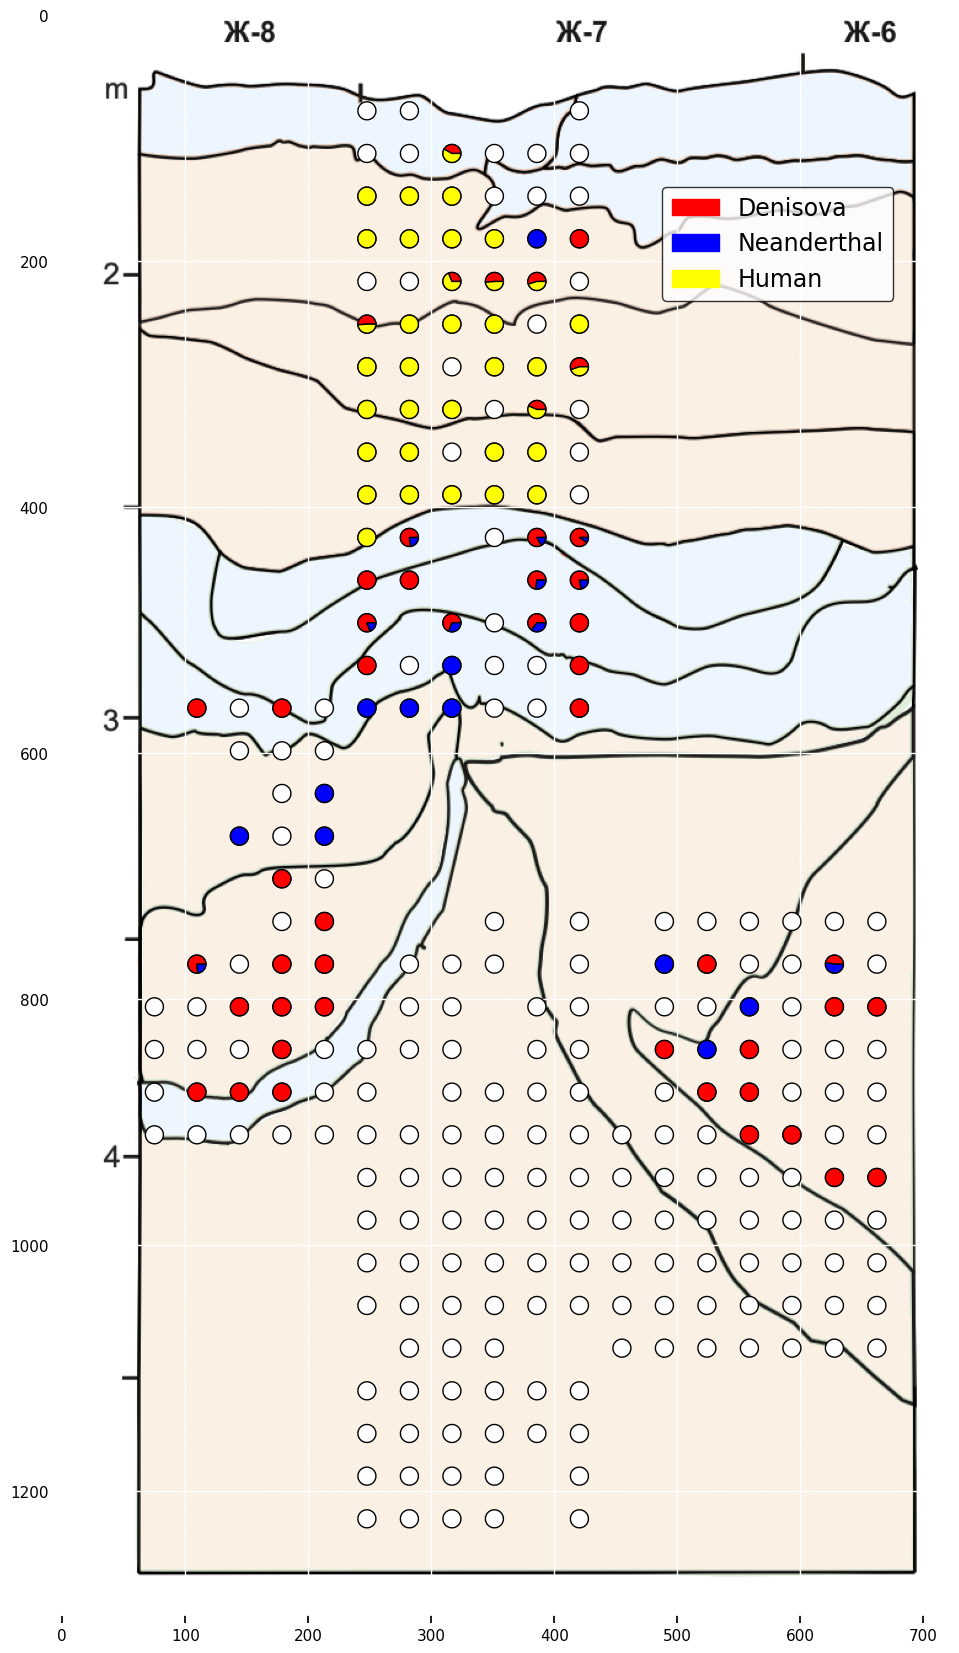

In [134]:
szy = convert_dataframe(pl)
print_map(szy)

In [135]:
# get some basic stats about number of samples etc
# import the quicksand results again (need that, as the raw quicksand output doesnt contain the sample id, only the library)
pl = pd.read_csv(
    f"assets/SI5/quicksand_Denisova_nochimp0.99_deam3.tsv", 
    sep='\t'
) 
pl = pl.applymap(lambda x: x.strip() if isinstance(x, str) else x)

pl['AncientCount'] = pl['Ancient'].apply(lambda x: x=='++')

pl_count = pl.groupby('SampleID', as_index=False).sum()
print('Ancient: ', len(pl_count[pl_count['AncientCount'] > 0]))
print('Negative: ', len(pl_count[pl_count['AncientCount'] == 0]))

Ancient:  100
Negative:  174


In [136]:
tmp1 = pl_count[['SampleID','AncientCount']].copy()
tmp2 = zav_count[['SampleID','AncientCount']].copy()
res = tmp1.merge(tmp2, on='SampleID')
res.columns = ['SampleID', 'PositiveQuicksand', 'PositiveZavala2021']

In [137]:
print('New Positive: ', len(res[(res.PositiveQuicksand != res.PositiveZavala2021)&(res.PositiveZavala2021==0)]))
print('Only Zavala 2021 positive: ', len(res[(res.PositiveQuicksand != res.PositiveZavala2021)&(res.PositiveQuicksand==0)]))

New Positive:  23
Only Zavala 2021 positive:  1


### Compare numbers

In [138]:
# lets check how the number of fragments compare to each other

In [139]:
pl.columns = ['DB_entry', 'QC', 'QC_comment', 'Comments', 'RunID', 'IndexLibID',
       'CapLibID', 'IndexLibIDCoreDB', 'CapLibIDCoreDB', 'p7', 'p5',
       'SampleID', 'ExtractID', 'SampleType', 'ExperimentType', 'ProbeSet',
       'Site', 'Description', 'CC_reads', 'CC_percent', 'RawSeqs',
       'ReadsFiltered', 'Identified', '%Hominin', 'ReadsMapped', '%Mapped', 'UniqueHominin',
       'DuplicationRate', "5CT", "3CT", "5CTCI", "3CTCI",
       "cond5'CT(95%CI)", "cond3'CT(95%CI)", 'Ancient', 'Deaminated(term3)',
       'H_support', 'H_support_deam', 'N-HST_support', 'N-HST_support_deam',
       'N_support', 'N_support_deam', 'HST_support', 'HST_support_deam',
       'D-S_support', 'D-S_support_deam', 'D_support', 'D_support_deam',
       'S_support', 'S_support_deam', 'H_der', 'H_deam_der', 'N-HST_der',
       'N-HST_deam_der', 'N_der', 'N_deam_der', 'HST_der', 'HST_deam_der',
       'D-S_der', 'D-S_deam_der', 'D_der', 'D_deam_der', 'S_der', 'S_deam_der',
       'Unnamed: 64', 'AncientCount']

In [140]:
# Add layer information to the dataset...

In [141]:
layerdata = pd.read_csv('assets/SI5/zavala2021_SD1_generalsummary.csv', skiprows=4)

In [142]:
layerdata = layerdata[[x for n,x in enumerate(layerdata.columns) if n in [3,4]]].copy()
layerdata.columns = ['Layer', 'SampleID']

In [143]:
layerdata.drop_duplicates('SampleID', inplace=True)

In [144]:
layerdata['Layer'] = layerdata.Layer.apply(lambda x: re.search('[0-9]+', str(x)).group() if bool(re.search('[0-9]+',str(x))) else x)

### Start again

In [145]:
pl['Pipeline'] = 'quicksand'
zavala21['Pipeline'] = 'BLAST+MEGAN'

combined = pd.concat([pl, zavala21[zavala21.Marker.fillna("").str.startswith('M')]], ignore_index=True)
combined['UniqueHominin'] = combined['UniqueHominin'].apply(lambda x: int(x))

In [146]:
#combined = combined.dropna(axis=1, how='any')
combined = combined[combined.SampleID.isin(['ENC','LNC'])==False]
combined['Ancient'] = combined["Ancient"].map({
    '-':'-',
    '+':"-",
    '++':'++',
    'Yes':'++',
    'No':'-',
    'YesNo':'-'})

In [147]:
combined = combined.merge(layerdata, on='SampleID', how='left', validate='m:1')
combined["Layer"] = combined.Layer.astype(int)

Text(0, 0.5, 'Hominin deaminated reads')

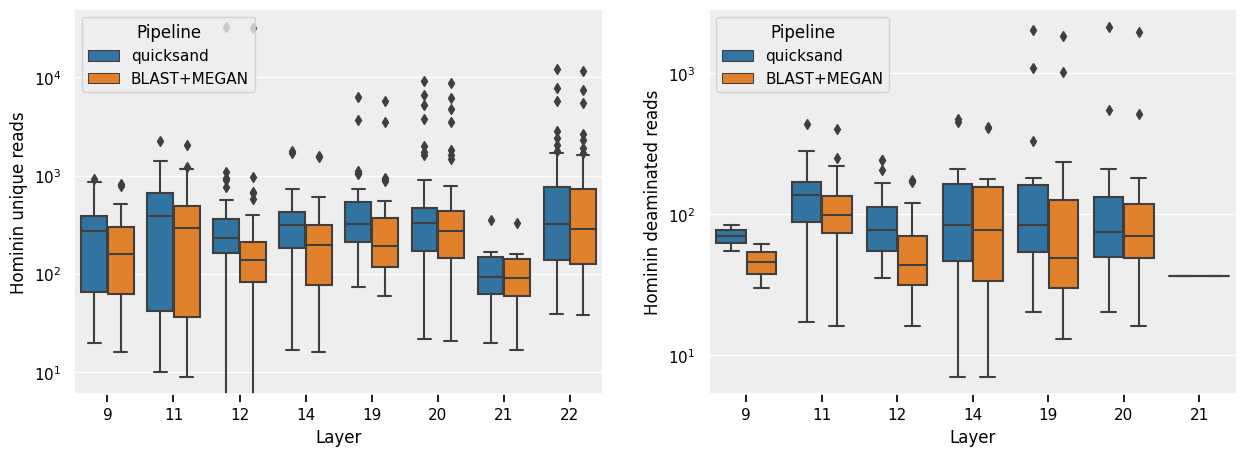

In [148]:
sns.set_context("notebook")

fig = plt.figure(figsize=(15,5))
ax=fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.boxplot(
    data=combined, 
    x="Layer", y="UniqueHominin",
    hue="Pipeline",
    ax=ax
)
sns.boxplot(
    data=combined[combined['Ancient']=='++'], 
    x="Layer", y="Deaminated(term3)",
    hue="Pipeline",
    ax=ax2
)

ax.set_yscale('log')
ax.set_ylabel("Hominin unique reads")

ax2.set_yscale('log')
ax2.set_ylabel('Hominin deaminated reads')

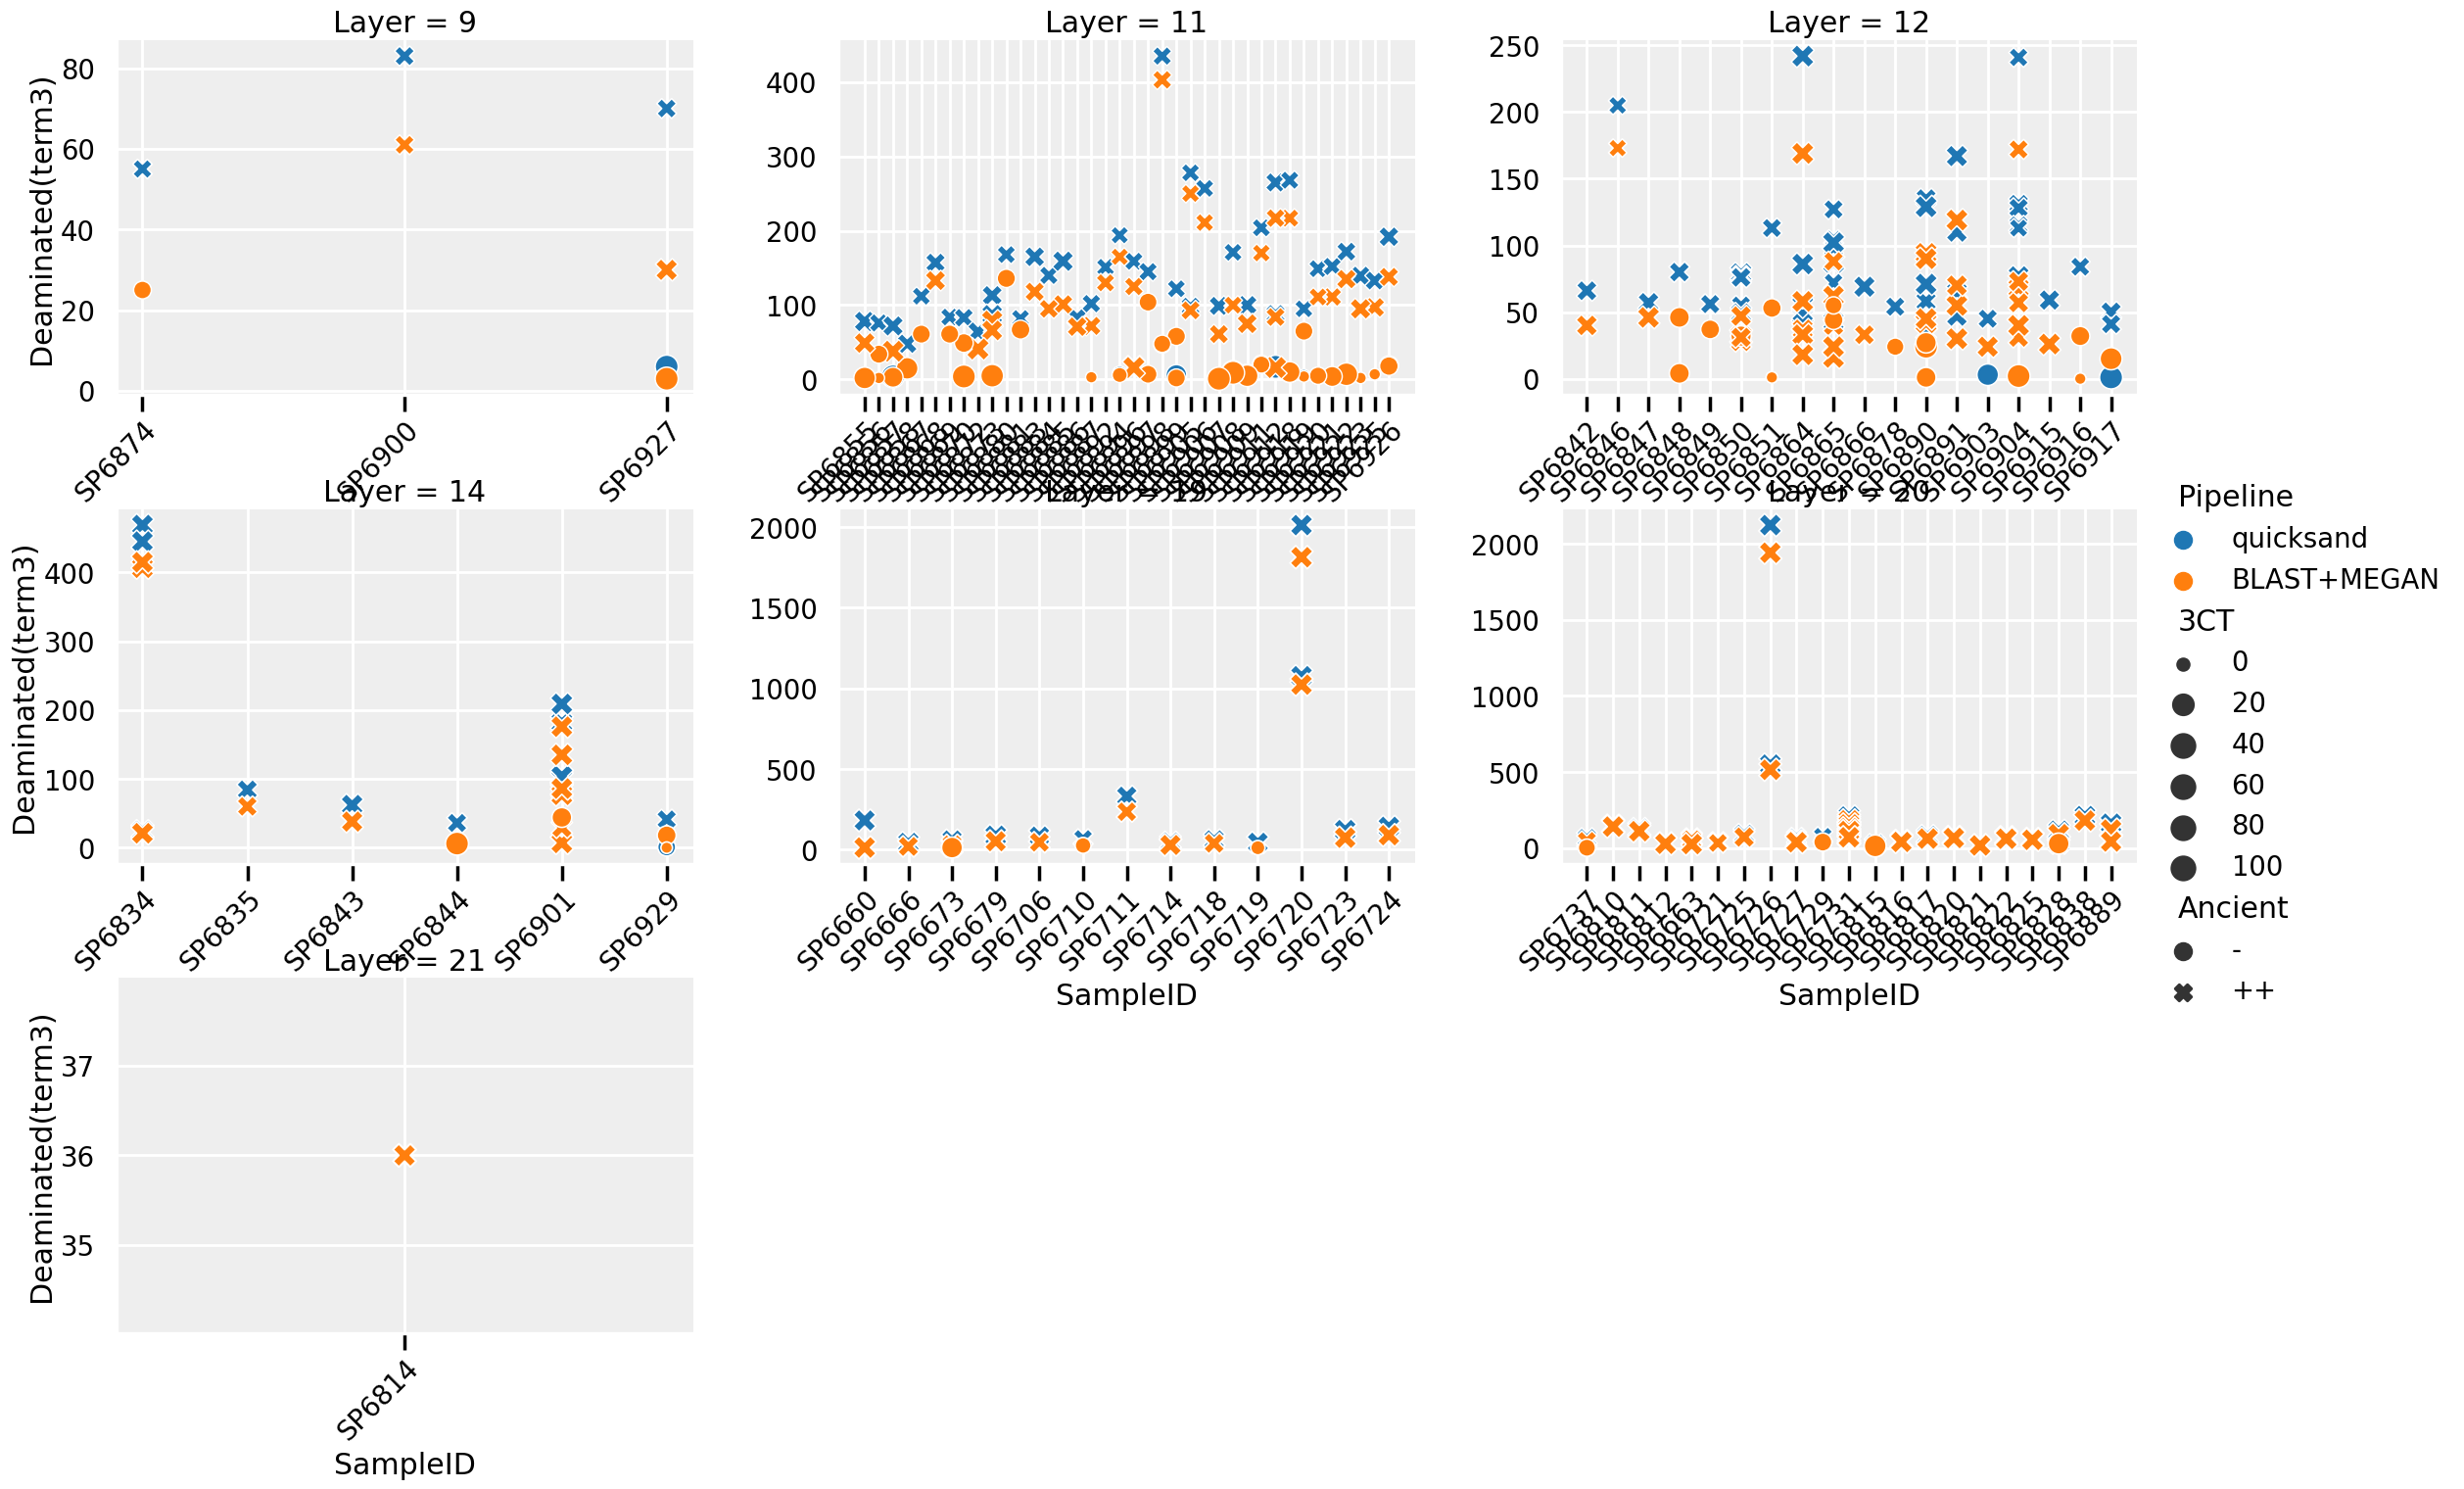

In [149]:
sns.set_context("poster", font_scale=0.9)

quicksand_positives = set(combined[(combined.Ancient=='++')&(combined.Pipeline=='quicksand')]['IndexLibID'])

g= sns.relplot(
    data=combined[combined.IndexLibID.isin(quicksand_positives)], 
    facet_kws={'sharex':False, 'sharey':False},
    kind="scatter", aspect = 1.5, 
    x="SampleID", 
    y="Deaminated(term3)",
    col='Layer', col_wrap=3,
    hue="Pipeline", 
    style='Ancient', style_order=['-','++'],
    size='3CT',
    size_norm=(0,30)
)
for axes in g.axes.flat:
    plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


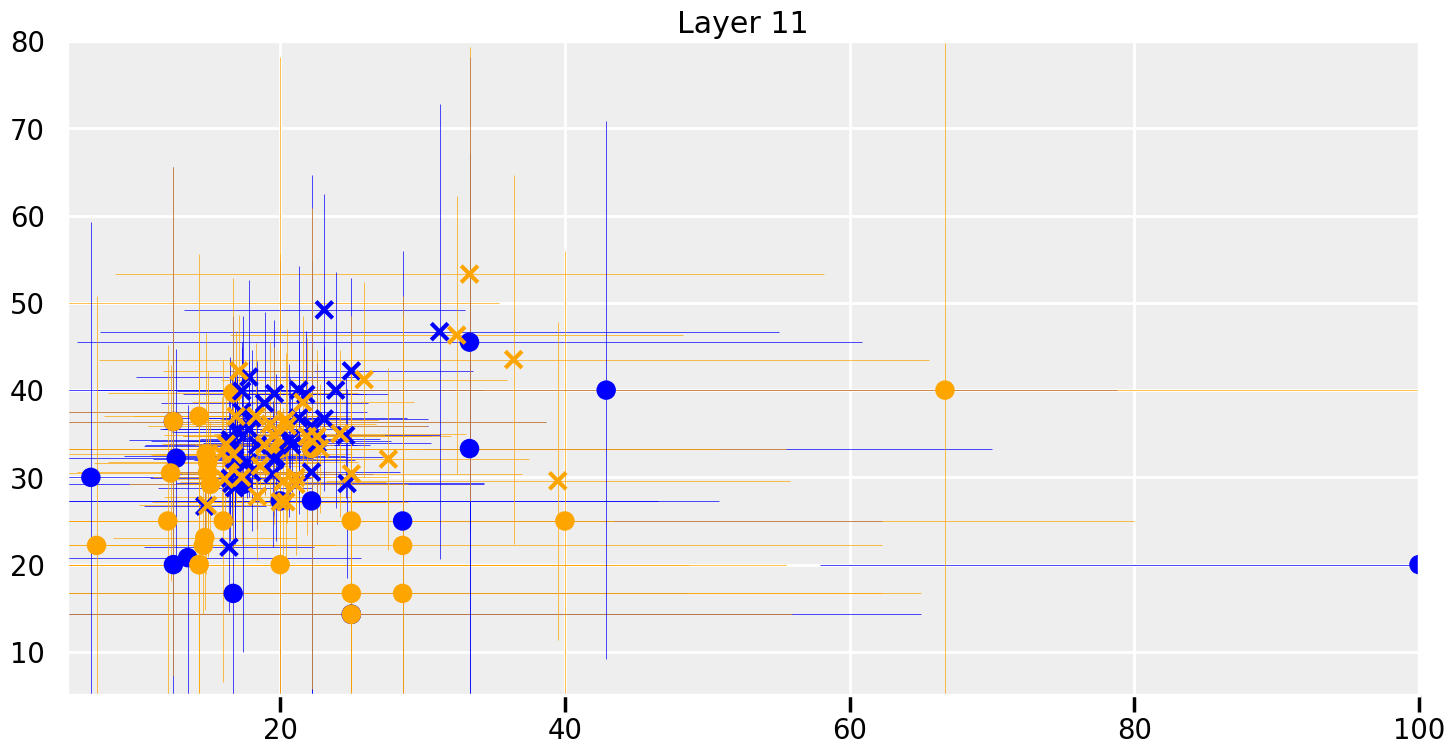

In [150]:
test = combined[(combined.Layer==11)&(combined.IndexLibID.isin(quicksand_positives))].copy()
test['color'] = test['Pipeline'].map({'quicksand':'blue', 'BLAST+MEGAN':'orange'})


def get_ci(x):
    if not x==x:
        return 0
    else:
        lower = re.search('[0-9]+\.[0-9]+',x).group()
        upper = re.search('(?<=\-)[0-9]+\.[0-9]+',x).group()
        return (float(upper)-float(lower))/2

test['CI3-ERROR'] = test['3CTCI'].apply(lambda x: get_ci(x))
test['CI5-ERROR'] = test['5CTCI'].apply(lambda x: get_ci(x))

fig=plt.figure(figsize=(15,8))

ax = plt.errorbar(
    test['3CT'], 
    test['5CT'], 
    xerr=test['CI3-ERROR'], 
    yerr=test['CI5-ERROR'],
    fmt="none",
    elinewidth=0.5,
    zorder=1,
    ecolor = test['color'],
)

plt.scatter(
    test[test.Ancient=='-']['3CT'], 
    test[test.Ancient=='-']['5CT'], 
    color = test[test.Ancient=='-']['color'],
    zorder=2
)
ax = plt.scatter(
    test[test.Ancient=='++']['3CT'], 
    test[test.Ancient=='++']['5CT'], 
    color = test[test.Ancient=='++']['color'],
    marker = 'x',
    zorder=2
)

ax.set_ylabel="5CT"
plt.xlabel="3CT"
plt.title('Layer 11')
plt.xlim(5,100)
plt.ylim(5,80)
plt.tight_layout()

The positive and negative samples fal into the same range of the 3' and 5' point estimates, however, quicksand has a bit smaller confidence intervals turning more samples positive

### Traces of Denisovans also in MEGAN?

In [151]:
df = convert_dataframe(combined, ancient=False)

df['support'] = df['value'].apply(lambda x: int(re.search("[0-9]+",x).group()))
df['sizes'] = df['value'].apply(lambda x: int(re.search("(?<=\()[0-9]+",x).group()))
df['sig']=df['value'].apply(lambda x: re.search("[\^\*]+",x).group() if bool(re.search('[\^\*]',x)) else "-")
df['Significance']=df['sig'].apply(lambda x: '^^^' if x=='**' else x)

df['h_sizes'] = df['H_support_deam'].apply(lambda x: int(re.search("(?<=\()[0-9]+",x).group()))
df['h_sig']=df['H_support_deam'].apply(lambda x: re.search("[\^\*]+",x).group() if bool(re.search('[\^\*]',x)) else "-")
df['h_Significance']=df['h_sig'].apply(lambda x: '^^^' if x=='**' else x)
df['h_support'] = df['H_support_deam'].apply(lambda x: int(re.search("[0-9]+",x).group()))


# for humans, use deaminated only
df['Significance'] = df[['variable', 'h_Significance', 'Significance']].apply(lambda x: x[1] if x[0]=='Human' else x[2], axis=1)
df['Fragments'] = df[['variable', 'h_sizes', 'sizes']].apply(lambda x: x[1] if x[0]=='Human' else x[2], axis=1)
df['Support'] = df[['variable', 'h_support', 'support']].apply(lambda x: x[1] if x[0]=='Human' else x[2], axis=1)
df['Group'] = df['variable']

In [152]:
df = df[(df.Fragments > 0)&(df.Group != 'Sima')].copy()

In [153]:
def print_relplot(df, y='Support'):
    g = sns.relplot(
        data=df,
        aspect=2,
        facet_kws={'sharex':False, 'sharey':True},
        kind="scatter", 
        x='SampleID',
        y=y,
        col='Group', 
        row='Layer',
        hue="Pipeline", 
        style='Significance', style_order=['-','^',"^^","^^^"],
        #size='Ancient', size_order=['++', '-'],
        #size_norm=(0,10)
    )

    for ax in g.axes.flat:
        ax.set_xticklabels([])
    #for axes in g.axes.flat:
    #    plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    #plt.tight_layout()

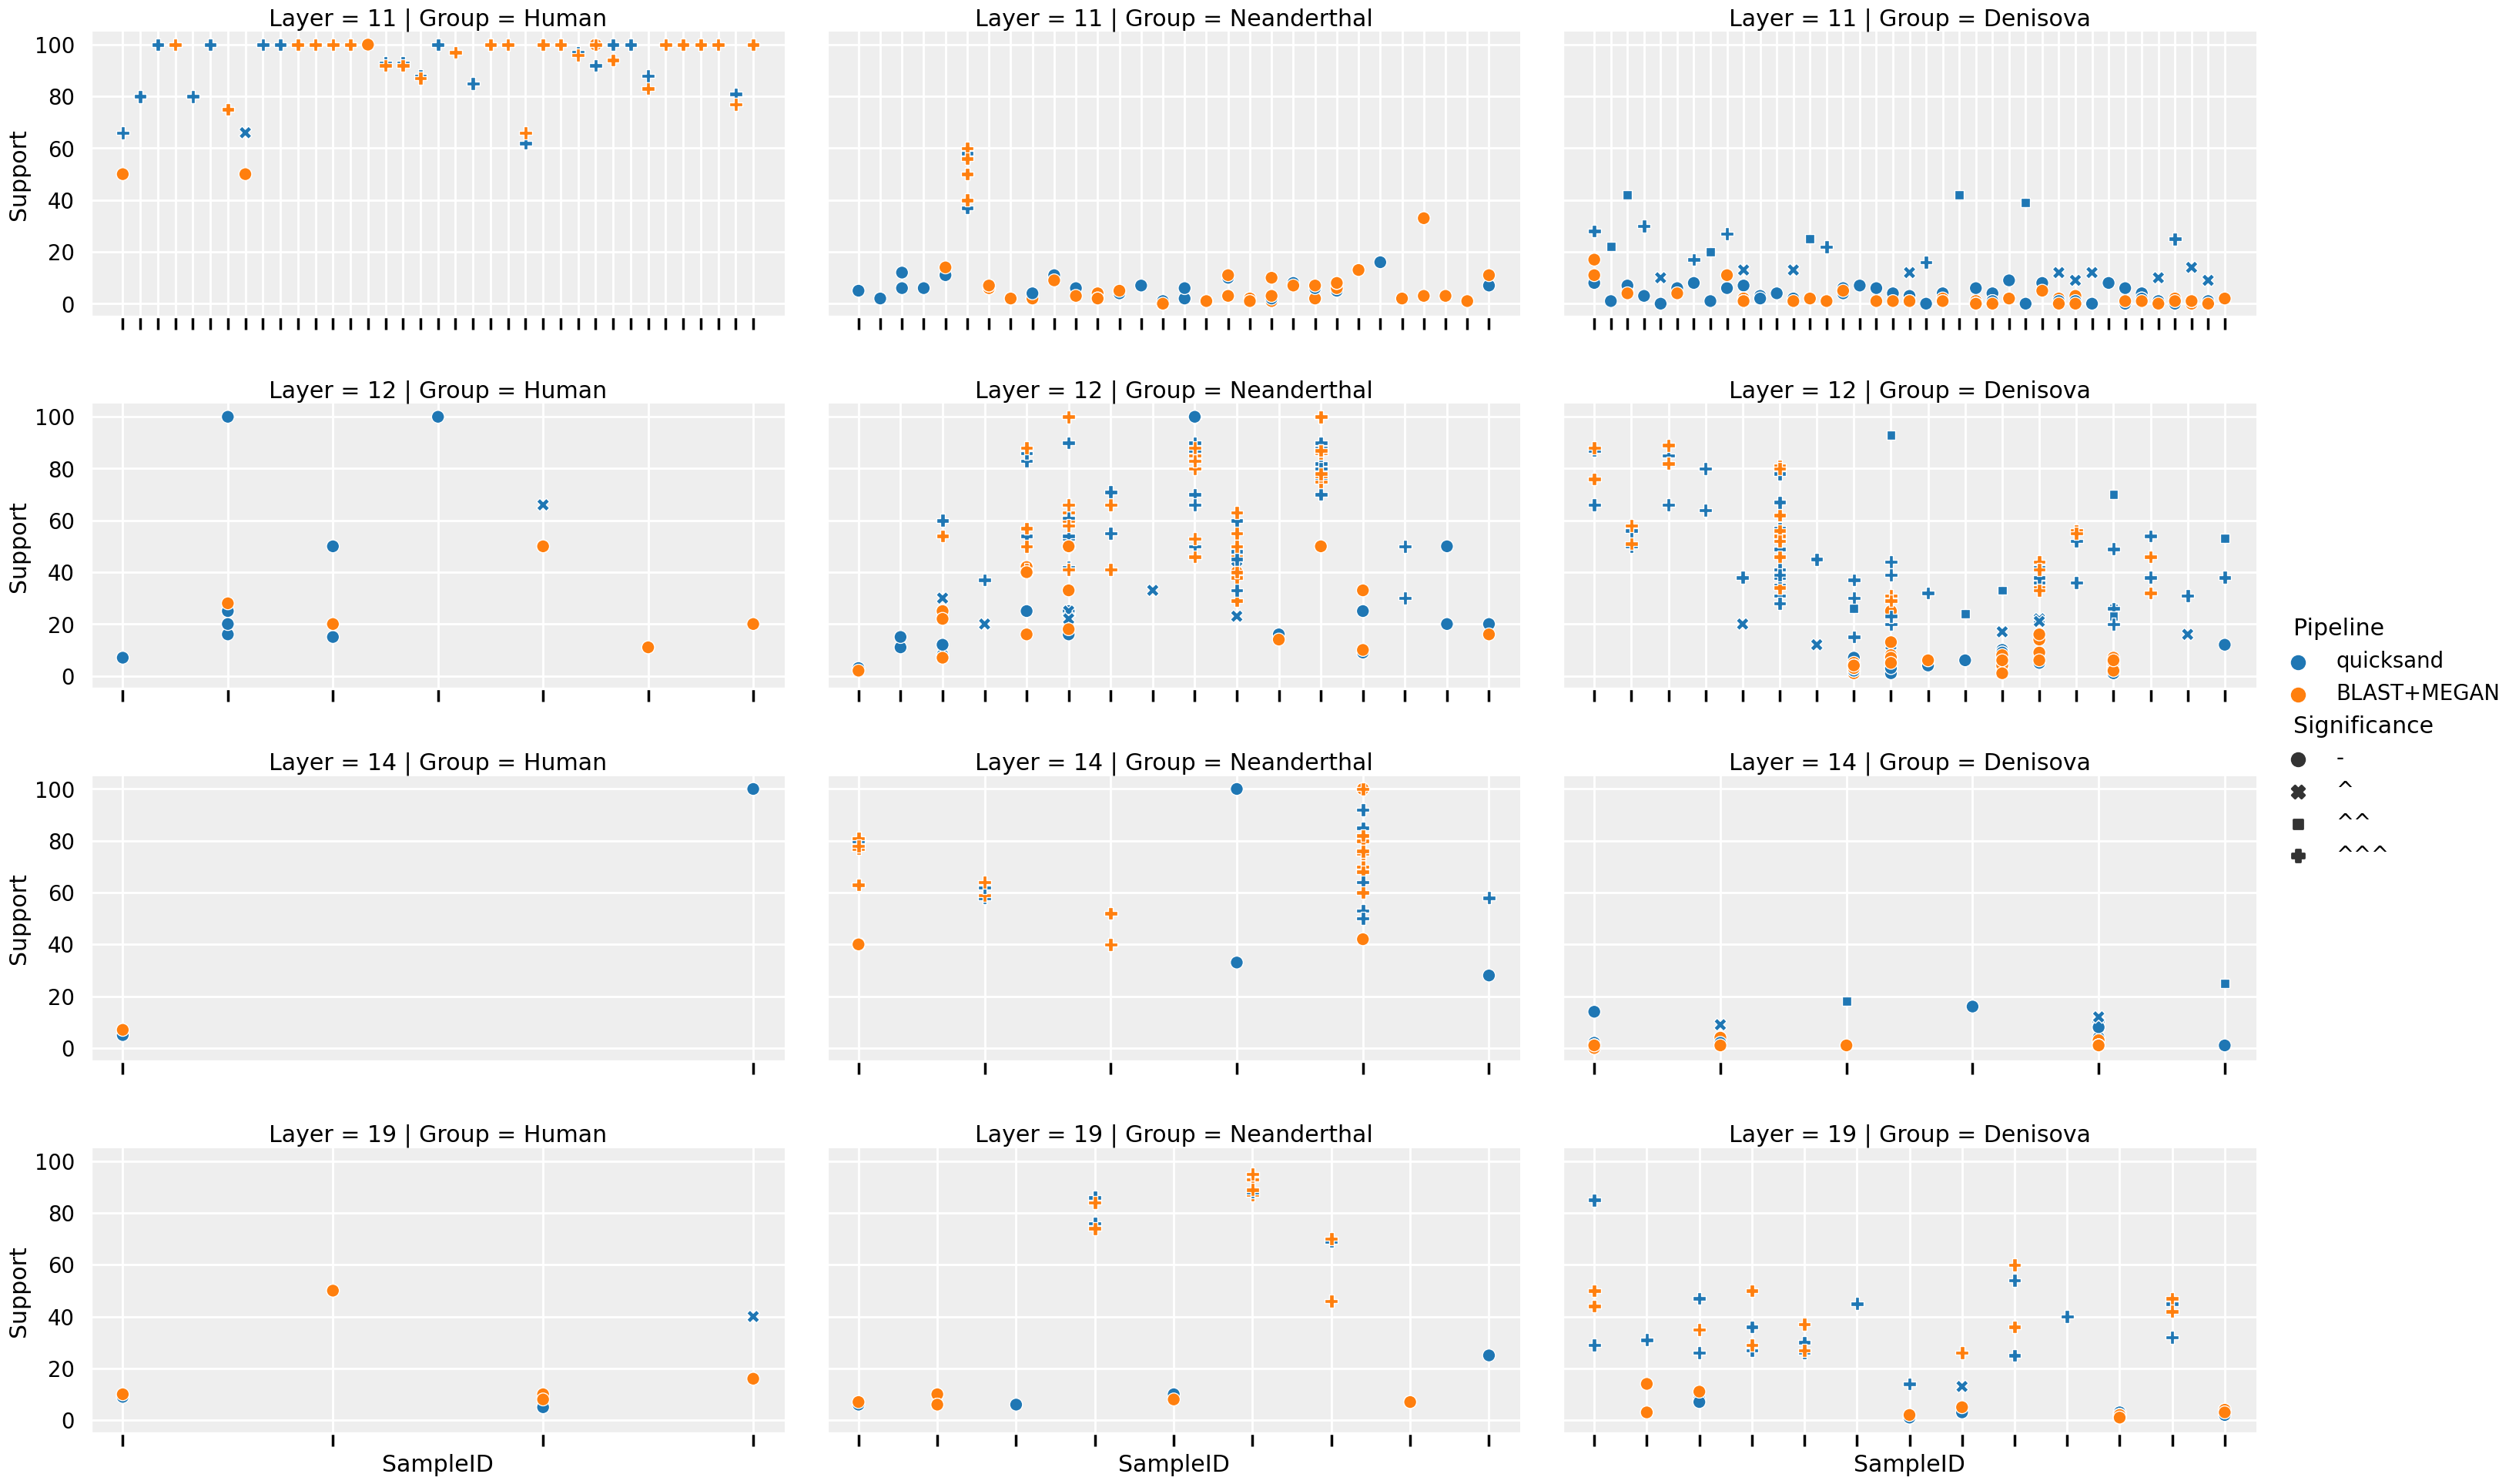

In [154]:
sns.set_context("poster", font_scale=0.9)

reduced = df[(df.Ancient=='++')&(df.Layer.isin([11,12,14,19]))]
print_relplot(reduced)

### Test the filters

Because we find a bit more denisovan support generally, lets check the results including the chimp in the set of diagnostic positions


In [155]:
qs = pd.read_csv("assets/SI5/quicksand_Denisova_merged_reports.tsv", sep='\t')

In [161]:
# import the quicksand perlscript results
pl = pd.read_csv(
    f"assets/SI5/quicksand_Denisova_chimp0.99_deam3.tsv", 
    sep='\t'
) 
pl = pl.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#in case we did some filtering on the quicksand 
pl = pl[pl.CapLibIDCoreDB.isin(qs.RG)].copy()

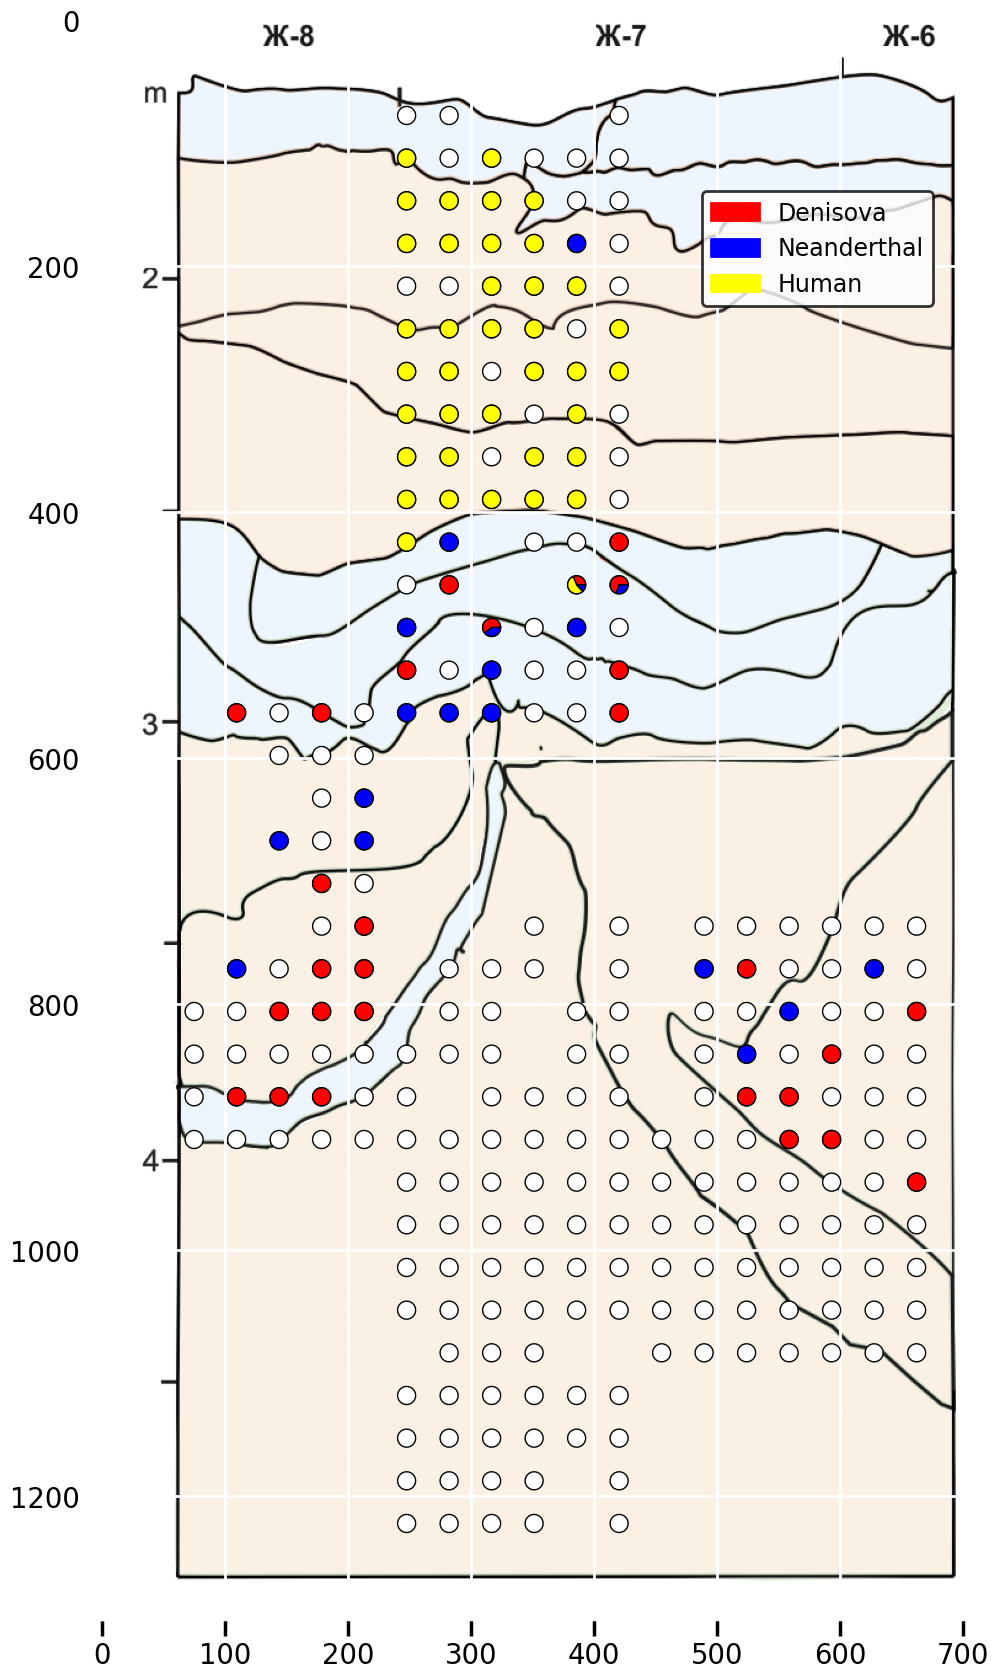

In [158]:
szy = convert_dataframe(pl)
print_map(szy)